### Build and train the vgg16 network and retrain it by breast cancer data base

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Import the liberaries

In [0]:
import torch
from torch import nn, optim
from torchvision import datasets ,transforms, models
import numpy as np
import matplotlib.pyplot as plt
import helper
import math
import time as evaltime
from torch import nn
from collections import OrderedDict
# !pip install pretrainedmodels
# import pretrainedmodels
import tqdm
from tqdm import tqdm
import pandas as pd

#################################
# If GPU is available, run the model in there 
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load the pre trained model and change the FC layer to taylor the number of classes 2.

In [0]:
vgg16= models.vgg16(pretrained=False)

## Load the pre trained model and change the FC layer to taylor the number of classes 2.

In [0]:
# Load the pretrained model 
vgg19= models.vgg19(pretrained=True)



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
# Define the classifier
classifier= nn.Sequential(OrderedDict([
    ('0', nn.Linear(25088,4096)),
    ('1',nn.ReLU(inplace=True)),
    ('2', nn.Dropout(p=0.5)),
    ('3', nn.Linear(4096,4096)),
    ('4',nn.ReLU(inplace=True)),
    ('5', nn.Dropout(p=0.5)),
    ('6', nn.Linear(4096,2)),
    ('output', nn.LogSoftmax(dim=1))
    
]))
# Add the classifier
vgg19.classifier=classifier

# Retrained all the parameters 
for params in vgg19.parameters():
    params.required_grad=True
    
for params in vgg19.classifier.parameters():
    params.required_grad=True

## Define the loss and optimization. in order to retrain the model, define the require grad true for all the parameters in the network.

In [ ]:
critirion= nn.NLLLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=0.0002)
vgg19.to(device)


### Load the images to the train and test loader, with the ratio of 90/10

In [0]:
dir_two_Classes='To the brest cancer images for two classification/'
dir_checkpoints='To the /checkpoints/'
dir_statistics='To the/statistics/'

# split the train and test datasets with the ration of 90/10
ratio=0.9 
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomResizedCrop((224,224),scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

# load the images to the train and test loader 
dataset= datasets.ImageFolder(dir_two_Classes,transform=train_transform)
train_sample_len=math.ceil(len(dataset)*ratio)
test_sample_len=len(dataset)-train_sample_len
trainset,testset=torch.utils.data.random_split(dataset,[train_sample_len,test_sample_len] )

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, num_workers=4, shuffle=True)
testloader =torch.utils.data.DataLoader(testset, batch_size=1, num_workers=4, shuffle=False)
classes=trainset.dataset.classes
print( len(dataset), classes)

7821 ['benign', 'malignant']


### Displaying one image out of all to be confirmed that the trainset is already loaded

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


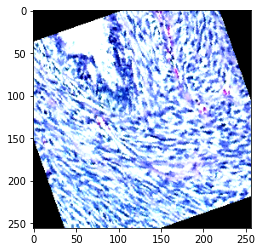

In [0]:
images=iter(testloader).next()
type(images)
images[0][0].shape
img=images[0][0].permute(1,2,0)

plt.imshow(img)

### Train and test the model

In [ ]:
epochs = 100
steps= 0
print_every=100
running_loss=0
min_val_loss = np.Inf
results={'epoch':[],'training_loss':[], 'test_loss':[], 'test_accuracy':[], 'training_accuracy':[]}

# Iterate through the epoches
for e in range(1,epochs+1):
  running_results={'loss':0, 'accuracy':0,'minutes':0,'steps':0}
  vgg19.train()
  train_bar=tqdm(trainloader)
  running_loss=0
    
   # Trian the model 
  for images, labels in train_bar:
      start_time= evaltime.time()
      images, labels = images.to(device), labels.to(device)
      running_results['steps']+=1
      optimizer.zero_grad()
      output=vgg19.forward(images)
      ps=torch.exp(output)
      loss=critirion(output,labels)
      loss.backward()
      optimizer.step()
      # running_loss+=loss.item()
      running_results['loss']+=loss.item()
      equality = (ps.max(dim=1)[1]==labels.data)
      running_results['accuracy']+=equality.type(torch.FloatTensor).mean()
      train_bar.set_description(desc='[%d/%d], training_loss: %.4f, training_accuracy: %.4f '% 
                                (e,epochs, running_results['loss']/running_results['steps'],running_results['accuracy']/running_results['steps']))
  test_bar=tqdm(testloader, desc='Validation Results:')
  vgg19.eval()
  valing_results={'test_loss':0, 'test_accuracy':0, 'min_loss':0, 'steps':0}

  # Do not change the parameters while evaluating the model 
  with torch.no_grad():
    # Test the model
    for images, labels in test_bar: 
      valing_results['steps']+=1
      images, labels = images.to(device), labels.to(device)
      output=vgg19.forward(images)
      loss=critirion(output,labels)
      valing_results['test_loss']+= loss.item()
      ps=torch.exp(output)
      equality = (ps.max(dim=1)[1]==labels.data)
      valing_results['test_accuracy']+=equality.type(torch.FloatTensor).mean()
      test_bar.set_description(desc='test_loss: %.4f, test_accuracy: %.4f'%
                               (valing_results['test_loss']/valing_results['steps'], valing_results['test_accuracy']/valing_results['steps'] ))
    if (valing_results['test_loss']/valing_results['steps']< min_val_loss):
            min_val_loss=valing_results['test_loss']/valing_results['steps']
            print('saving the model with min loss of : '+ str(min_val_loss))
            torch.save(vgg19.state_dict(),dir_checkpoints+"vgg19.pth")

  # update the results for each epoch        
  results['training_loss'].append(running_results['loss']/running_results['steps'])
  results['test_loss'].append(valing_results['test_loss']/valing_results['steps'])
  results['test_accuracy'].append(valing_results['test_accuracy'].item()/valing_results['steps'])
  results['training_accuracy'].append(running_results['accuracy'].item()/running_results['steps'])
  
  data_frame=pd.DataFrame(
        data={
            # 'Epoch':1,
            'Training_Loss':results['training_loss'],
            'Test_Loss': results['test_loss'],
            'Test_Accuracy':results['test_accuracy'],
            'Training_Accuracy':results['training_accuracy'],
           
                 },
        index=range(1,e+1)
    )

  # Save the results into a CSV file 
  data_frame.to_csv(dir_statistics+ 'vgg19_eval_results.csv',  index_label="Epoch")    
